### Import the Datasets

In [2]:
import pandas as pd
users_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,22/04/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,15/11/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,19/03/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,21/05/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,17/01/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [4]:
user_eng_df = pd.read_csv('takehome_user_engagement.csv')
user_eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_eng_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


### Labelling a user as adopted

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption .

In [9]:
import datetime
from datetime import timedelta

In [8]:
user_eng_df['time_stamp'] = pd.to_datetime(user_eng_df['time_stamp'])
user_eng_df.set_index('time_stamp', inplace=True)

In [11]:
def label_adopted(x):    
    "input the user and check if they have been active within any 7-day period"
    df_temp = user_eng_df.loc[user_eng_df['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [12]:
users_df['adopted_user'] = users_df['object_id'].apply(label_adopted)

In [14]:
print(sum(users_df['adopted_user']))
print(sum(users_df.adopted_user)/len(users_df.adopted_user))

1656
0.138


Around 14 percent of the entire data has adopted users. Might be later we have to deal with class imbalance. 

### Data Wrangling

Convert all time stamps to datetime objects

In [16]:
# set creation_time
users_df.creation_time = pd.to_datetime(users_df.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

Finding the user active time

In [17]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])
#subtract to find time active
users_df['usage_length'] = users_df['last_session_creation_time'] - users_df['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
users_df['usage_length'] = [x.total_seconds() for x in users_df['usage_length']]

Also using email domain as a feature. Only considering the few important ones 

In [18]:
users_df['email_provider'] = [x.split('@')[1] for x in users_df.email]#select out the domain
top_emails = users_df.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
users_df['email_provider'] = [x if x in top_emails else 'other' for x in users_df.email_provider]

We will do label encoding so need to ensure there are no null values

In [19]:
users_df.invited_by_user_id = users_df.invited_by_user_id.fillna(0)

We filter out the columns that are needed for analysis

In [20]:
feature_df = users_df.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,GUEST_INVITE,1,0,11,10803.0,0,19830.0,yahoo.com
1,ORG_INVITE,0,0,1,316.0,1,11770204.0,gustr.com
2,ORG_INVITE,0,0,94,1525.0,0,19852.0,gustr.com
3,GUEST_INVITE,0,0,1,5151.0,0,106228.0,yahoo.com
4,GUEST_INVITE,0,0,193,5240.0,0,451820.0,yahoo.com


### Label Encoding

In [22]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users_df['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users_df['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users_df['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(users_df['email_provider'])
feature_df.email_provider = email_labels

In [23]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,19830.0,6
1,1,0,0,56,316.0,1,11770204.0,2
2,1,0,0,298,1525.0,0,19852.0,2
3,0,0,0,1104,5151.0,0,106228.0,6
4,0,0,0,1127,5240.0,0,451820.0,6


### Analysis

Since we have a small feature set and sample size, Kneighbors and RandomForestClassifier are both good choices for this data set. However, we have a mix of categorical and numerical data so RandomForestClassifier will be easiest to implement.

In [24]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [25]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9265151515151515

This looks very promising

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3407
           1       0.79      0.64      0.71       553

    accuracy                           0.93      3960
   macro avg       0.87      0.81      0.83      3960
weighted avg       0.92      0.93      0.92      3960

confusion matrix:
[[3315   92]
 [ 199  354]]


considering that RandomForestClassifier is better at intrinsically describing data over predictive power, these results are very impressive, especially with imbalanced class representation

### Feature Importance

In [27]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.833432
invited_by_user_id            0.055448
org_id                        0.051996
email_provider                0.030916
creation_source               0.014932
opted_in_to_mailing_list      0.008495
enabled_for_marketing_drip    0.004781
Name: coef, dtype: float64

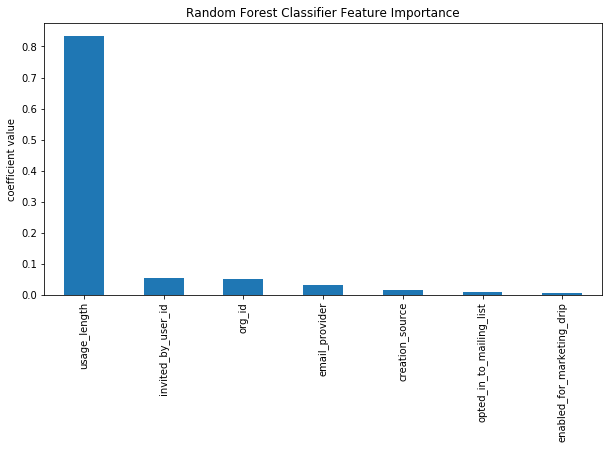

In [29]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

According to this analysis, RandomForestClassifer identified how long between when a user signed up and when their last active session to be the greatest indicator of whether or not they became an adopted user. Lets see what that means in a post hoc visualization


In [30]:
#define func to find ecdf of dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [31]:
adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 1]
not_adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 0]


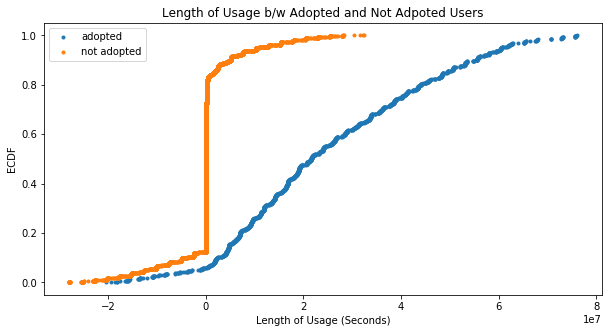

In [33]:
#set fig size
%matplotlib inline
import numpy as np
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Here it is apparent that at the maxium time usage of non-adopted users, approximately 60% of the active users have usage above that amount of time.